Данный файл является сугубо рабочим. В нем проводился анализ алгоритмов индексаций: IVF, PQ и их комбинации и вариации. А также строковой подход faiss. 

In [ ]:
#!pip3 install skimpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se
from sklearn.utils.class_weight import compute_class_weight

from skimpy import skim
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

import random
import faiss
from faiss import write_index, read_index

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
import random
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\practicum\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *target.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

Загрузим данные из base и target. Посмотрим как они выглядят, есть ли очень большие выбросы и т.д. 

## Base data

In [2]:
df_base = pd.read_csv("data/base.csv", index_col=0)

In [3]:
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [4]:
df_base.shape

(2918139, 72)

In [5]:
print("Количество уникальных индексов: ", len(df_base.index.unique()))

Количество уникальных индексов:  2918139


In [6]:
#skim(df_base)

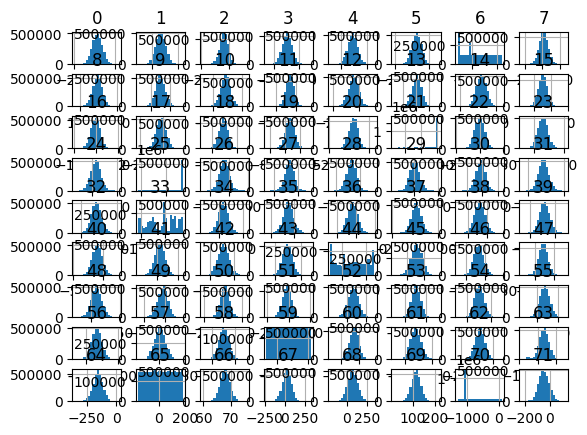

In [7]:
df_base.hist(bins=20)
print()

In [4]:
bad_features= ['6', '21', '25', '44', '59', '70', '65', '33']

In [5]:
df_base.drop(bad_features, axis=1, inplace=True)

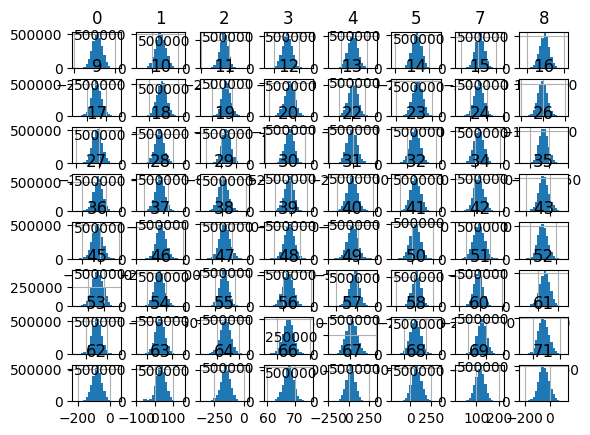

In [10]:
df_base.hist(bins=20)
print()

In [11]:
cor_data = df_base.corr()

In [12]:
cor_data

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
0,1.000000,-0.018697,0.027923,-0.018087,0.041373,-0.028934,-0.005590,-0.000954,-0.006815,0.023097,...,-0.012306,0.041890,-0.019047,0.040108,0.007845,0.002094,0.027372,-0.008185,-0.019688,0.025474
1,-0.018697,1.000000,0.003489,0.009516,-0.020742,0.033579,0.045928,0.004558,-0.036872,-0.073076,...,-0.031524,-0.035945,0.011564,-0.143105,0.009382,0.055787,0.013307,-0.016829,0.030559,-0.015989
2,0.027923,0.003489,1.000000,-0.002529,0.004470,-0.053786,0.028222,0.002511,-0.001074,0.009154,...,-0.038005,-0.028917,-0.014118,0.017518,0.062886,-0.027636,-0.000426,-0.037688,0.041420,-0.042930
3,-0.018087,0.009516,-0.002529,1.000000,-0.007023,-0.002381,-0.001561,-0.014474,-0.011116,0.026432,...,0.007735,-0.016073,-0.006192,0.021684,-0.003276,-0.032467,-0.000672,0.023795,0.011546,-0.005703
4,0.041373,-0.020742,0.004470,-0.007023,1.000000,0.016437,-0.014905,-0.003597,0.016579,0.015475,...,-0.005250,-0.019423,-0.012220,-0.005466,0.024066,0.011873,0.023648,0.003213,-0.029733,0.042965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,0.002094,0.055787,-0.027636,-0.032467,0.011873,0.040542,0.030942,-0.002354,-0.009921,-0.065046,...,0.005222,-0.010681,0.008548,-0.068971,-0.024326,1.000000,-0.001923,0.021646,-0.002153,0.033178
67,0.027372,0.013307,-0.000426,-0.000672,0.023648,0.000202,-0.027490,-0.002774,-0.033970,0.037953,...,-0.003048,0.038236,0.002169,-0.004534,-0.019759,-0.001923,1.000000,0.064004,0.011851,0.014298
68,-0.008185,-0.016829,-0.037688,0.023795,0.003213,0.039225,0.011502,-0.011695,-0.004357,-0.013861,...,0.021198,-0.016946,0.005405,-0.024634,-0.040964,0.021646,0.064004,1.000000,0.007432,0.058548
69,-0.019688,0.030559,0.041420,0.011546,-0.029733,-0.000287,0.007841,0.016029,-0.006965,-0.007043,...,0.035034,-0.034803,0.030081,-0.020232,0.018247,-0.002153,0.011851,0.007432,1.000000,0.000295


## Train data

In [6]:
df_train = pd.read_csv("data/train.csv", index_col=0)
df_train.drop(bad_features, axis=1, inplace=True)

In [6]:
df_train.shape

(100000, 65)

In [15]:
df_train.head()

,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,66,67,68,69,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,38.307602,109.085560,30.413513,-88.08269,...,-132.38617,-105.427820,70.107360,-155.80257,65.903790,34.457500,62.642094,134.763600,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-78.433090,124.915900,140.331070,-177.60580,...,-137.41136,-40.812233,4.669178,-151.69771,68.170876,25.096191,89.974976,130.589630,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,-30.447489,125.771164,211.607820,-86.34656,...,-139.22307,-52.031662,78.039764,-169.14620,66.008220,18.400496,212.409730,121.931470,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,79.186520,124.003100,242.650650,-146.51707,...,-131.19829,-61.567047,44.515266,-145.41675,64.131350,106.061920,83.178760,118.277725,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,45.984676,125.941284,103.392670,-107.15302,...,-103.34170,-68.770600,45.028910,-196.09207,66.926220,42.456170,77.621765,92.479930,-21.149351,717819-base


In [16]:
skim(df_train)

In [7]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

## Validation data

In [8]:
df_validation = pd.read_csv("data/validation.csv", index_col=0)
df_validation_answer = pd.read_csv("data/validation_answer.csv", index_col=0)
df_validation.drop(bad_features, axis=1, inplace=True)

In [19]:
df_validation.head()

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,139.815720,112.880980,75.215750,-131.89280,...,45.506813,-144.19095,-75.51302,52.830902,-143.43945,69.28224,61.927513,111.59253,115.140656,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,63.995087,127.117905,53.128998,-153.71725,...,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,70.76560,-65.975950,97.07716,123.391640,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,87.477554,131.270110,168.920320,-220.30954,...,5.522629,-126.81297,-134.79541,37.368730,-159.66231,67.71044,86.002060,137.63641,141.081630,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,-19.046660,115.042404,75.206730,-114.27196,...,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,70.88396,23.577892,133.18396,143.252940,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,34.411217,128.903980,102.086914,-76.21417,...,-11.433113,-135.57036,-123.77025,45.635944,-134.25893,70.61763,15.332115,154.56812,101.700640,-125.307890


In [20]:
df_validation_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


# Обучение

## Масштабирование

In [9]:
scale = MinMaxScaler(feature_range = (-2, 2))
base_scaled = scale.fit_transform(df_base)
train_scaled = scale.transform(df_train)
validation_scaled = scale.transform(df_validation)

## Первый этап обучения

### Nearest Neighbors (scikit-learn)

In [21]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(base_scaled)

NearestNeighbors()

In [ ]:
ans = neigh.kneighbors(validation_scaled, 20, return_distance=False)

In [9]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [ ]:
acc = 0
for target, el in zip(targets.values.tolist(), ans.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(ans))

### Faiss

In [17]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [10]:
def my_split(arr: np.ndarray, intersection_int = 10, length=34): 
    if length == arr.shape[1]:
        return [arr]
    if intersection_int >= length:
        intersection_int = length - 1
        print(f"Пересечение изменено на {intersection_int}")
    dim = arr.shape[1]
    flag1 = 0
    flag2 = flag1 + length
    part = []
    while flag1 < dim:
        if flag2 >= dim:
            part.append(arr[:, dim-length:])
            print(f"Разделено на {len(part)} частей")
            return part
        else:
            part.append(arr[:, flag1:flag2])
        flag1 = flag1 + length - intersection_int
        flag2 = flag1 + length
    print(f"Разделено на {len(part)} частей")
    return part

In [11]:
def random_split(arr: np.ndarray, parts = 3, length=34):
    if parts == 1:
        return [arr]
    dim = arr.shape[1]
    random.seed(42)
    columns = [i for i in range(dim)]
    part = []
    for i in range(parts):
        randim_columns = random.sample(columns, length)
        part.append(arr[:, randim_columns])
    return part

#### IndexIVFFlat

In [514]:
def cut_vector_IVFFlat(base, test, base_index, true_target: pd.Series, n_cells=250, nprobe=5, parts=3, length=34, out_one=5):
    idx_all = []
    vecs_all = []
    models = []
    
    dates = random_split(base, parts = parts, length=length)
    tests = random_split(test, parts = parts, length=length)
    
    parts = len(dates)
    for i in range(parts):
        
        dims = dates[i].shape[1]
        #quantizer = faiss.IndexFlatL2(dims)
        
        M_mi = 2
        nbits_mi = 10
        ncentroids_mi = 2 ** (M_mi * nbits_mi)
        coarse_quantizer_mi = faiss.MultiIndexQuantizer(dims, M_mi, nbits_mi)
        
        idx_IVFFlat = faiss.IndexIVFFlat(coarse_quantizer_mi, dims, ncentroids_mi, faiss.METRIC_L2) #METRIC_L2
        idx_IVFFlat.nprobe = nprobe
        idx_IVFFlat.quantizer_trains_alone = True
        
        idx_IVFFlat.train(np.ascontiguousarray(dates[i]).astype('float32'))
        idx_IVFFlat.add(np.ascontiguousarray(dates[i]).astype('float32'))
        models.append(idx_IVFFlat)
        vecs, idx = idx_IVFFlat.search(np.ascontiguousarray(tests[i]).astype('float32'), out_one)
        idx_all.append(idx)
        vecs_all.append(vecs)
        
        acc = 0
        for target, el in zip(true_target.values.tolist(), idx.tolist()):
            acc += int(target in [base_index[r] for r in el if r != -1])
        print(f"Accuracy on the part {i+1} = {100 * acc / len(idx)}%")
        
    full_idx = np.concatenate(idx_all, axis=1)
    full_vecs = np.concatenate(vecs_all, axis=1)

    acc = 0
    for target, el in zip(true_target.values.tolist(), full_idx.tolist()):
        acc += int(target in [base_index[r] for r in el if r != -1])
    print(f"Total accuracy = {100 * acc / len(full_idx)}%")
    
    #Сортируем массив
    sum = []
    arr = np.array([full_vecs, full_idx])
    for i in range(len(full_vecs)):
        b = arr[:,i,:][:, :].argsort(axis=1)
        b = b[0].tolist()
        arr[:,i,:] = arr[:,i,b]
        
    #Ищем уникальные значения
    for i in range(len(full_vecs)):
        numb, ind = np.unique(arr[:,0,:][1], return_index=True)
        ind = sorted(ind.tolist())
        arr[:,0,ind]
     
    #Убираем лишнее, сохраняя исходную размерность
    new = np.full(arr[:,:,:].shape, -1, dtype='float64')
    for i in range(len(full_vecs)):
        numb, ind = np.unique(arr[:,i,:][1], return_index=True)
        ind = sorted(ind.tolist())
        new[:,i,:len(ind)] = arr[:,i,ind]  
        
    idx = new[1,:,:100].astype(int)
    acc = 0
    for target, el in zip(true_target.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el if r != -1])
    print(f"Accuracy on first {100} samples in sort array = {100 * acc / len(idx)}%")
    
    return full_vecs, full_idx, models, 100*acc/len(full_idx)

In [516]:
IVFFlat = cut_vector_IVFFlat(base_scaled, train_scaled, base_index, 
                             targets, nprobe=4000, parts=4, length=50, out_one=50)

Accuracy on the part 1 = 77.683%
Accuracy on the part 2 = 77.535%
Accuracy on the part 3 = 77.659%
Accuracy on the part 4 = 77.596%
Total accuracy = 79.749%
Accuracy on first 50 samples in sort array = 79.571%


Text(0.5, 1.0, 'nprobe=300, length=34, out_one=20')

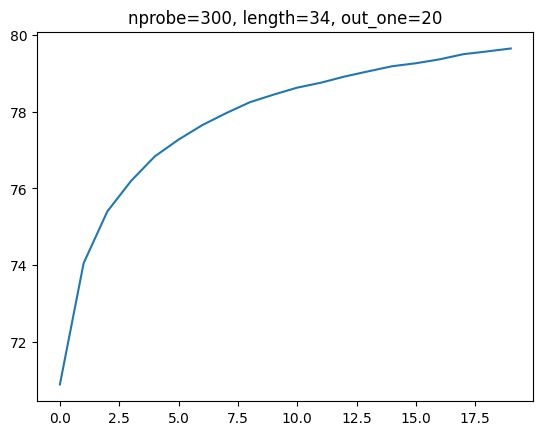

In [78]:
#nprobe=300, parts=20, length=34, out_one=20
#17 242 259 rows выходные
accuracy = [70.888, 74.049, 75.4, 76.195, 76.834, 77.272, 77.649,
            77.96, 78.245, 78.443, 78.626, 78.755, 78.916, 79.052, 79.184, 79.262, 79.364,
           79.498, 79.57, 79.647]
plt.plot(accuracy)
plt.title("nprobe=300, length=34, out_one=20")
plt.show()

In [ ]:
#nprobe=4000, parts=15, length=34, out_one=20
#total acc = 79.354%
#12 553 974 rows выходные

In [ ]:
#nprobe=4000, parts=1, length=64, out_one=125
#total acc = 79.663%
#12 553 974 rows выходные

#### IndexPQ

In [ ]:
dims = base_scaled.shape[1]
m = 13
nbits = 8
idxPQ = faiss.IndexPQ(dims, m, nbits)
idxPQ.nprobe = 5

In [ ]:
idxPQ.train(np.ascontiguousarray(base_scaled).astype('float32'))

idxPQ.add(np.ascontiguousarray(base_scaled).astype('float32'))

In [ ]:
vecs, idx = idxPQ.search(np.ascontiguousarray(train_scaled).astype('float32'), 5)

In [ ]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

#### IndexIVFPQ

In [14]:
def cut_vector_IVFPQ(base, test, base_index, true_target: pd.Series, nbits = 10,
                     m = 16, n_cells=50, nprobe=5, parts=3, length=34, out_one=5):
    idx_all = []
    vecs_all = []
    models = []
    
    
    dates = np.array_split(base, parts, axis=1)
    tests = np.array_split(test, parts, axis=1)
    
        
    #dates = my_split(base, intersection_int = 0, length=length)
    #tests = my_split(test, intersection_int = 0, length=length)
    
    #dates = random_split(base, parts = parts, length=length)
    #tests = random_split(test, parts = parts, length=length)
    
    parts = len(dates)
    for i in tqdm(range(parts)):
        dims = dates[i].shape[1]
        
        quantizer = faiss.IndexFlatL2(dims)
        
        
        idx_IVFPQ = faiss.IndexIVFPQ(quantizer, dims, n_cells, m, nbits)
        idx_IVFPQ.nprobe = nprobe
        idx_IVFPQ.do_polysemous_training = True
        
        opq = faiss.OPQMatrix(dims, m)
        index_opq = faiss.IndexPreTransform(opq, idx_IVFPQ)
        
        rq = faiss.IndexRefineFlat(index_opq)
        rq.train(np.ascontiguousarray(dates[i]).astype('float32'))
        rq.add(np.ascontiguousarray(dates[i]).astype('float32'))
        rq.k_factor = 4
        
        rq.search_type = faiss.IndexPQ.ST_polysemous
        rq.polysemous_ht = 54
        
        write_index(rq, f"IVFPQ_nbits{nbits}_m{m}_n_cells{n_cells}_nprobe{nprobe}_parts{parts}_length{length}_out_one{out_one}_part№{i}.index")
        
        models.append(rq)
        
        vecs, idx = rq.search(np.ascontiguousarray(tests[i]).astype('float32'), out_one)
        idx_all.append(idx)
        vecs_all.append(vecs)
        
        acc = 0
        for target, el in zip(true_target.values.tolist(), idx.tolist()):
            acc += int(target in [base_index[r] for r in el if r != -1])
        print(f"Accuracy on the part {i+1} = {100 * acc / len(idx)}%")
        
    full_idx = np.concatenate(idx_all, axis=1)
    full_vecs = np.concatenate(vecs_all, axis=1)
    
    acc = 0
    for target, el in zip(true_target.values.tolist(), full_idx.tolist()):
        acc += int(target in [base_index[r] for r in el if r != -1])

    print(f"Total accuracy = {100 * acc / len(full_idx)}%")
    
    sum = []
    arr = np.array([full_vecs, full_idx])
    for i in range(len(full_vecs)):
        b = arr[:,i,:][:, :].argsort(axis=1)
        b = b[0].tolist()
        arr[:,i,:] = arr[:,i,b]
        
    #Ищем уникальные значения
    for i in range(len(full_vecs)):
        numb, ind = np.unique(arr[:,0,:][1], return_index=True)
        ind = sorted(ind.tolist())
        arr[:,0,ind]
     
    #Убираем лишнее, сохраняя исходную размерность
    new = np.full(arr[:,:,:].shape, -1, dtype='float32')
    for i in range(len(full_vecs)):
        numb, ind = np.unique(arr[:,i,:][1], return_index=True)
        ind = sorted(ind.tolist())
        new[:,i,:len(ind)] = arr[:,i,ind]  
        
    idx = new[1,:,:200].astype(int)
    acc = 0
    for target, el in zip(true_target.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el if r != -1])
    print(f"Accuracy on first {200} samples in sort array = {100 * acc / len(idx)}%")
    
    return full_vecs, full_idx, models, 100*acc/len(full_idx)

In [15]:
IVFPQ = cut_vector_IVFPQ(base_scaled, train_scaled, base_index, targets,  nbits = 10,
                     m = 23, n_cells=150, nprobe=50, parts=2, length=46, out_one=200)

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy on the part 1 = 80.389%
Accuracy on the part 2 = 80.385%
Accuracy on the part 3 = 80.343%
Total accuracy = 82.222%
Accuracy on first 200 samples in sort array = 81.493%


In [ ]:
#Выполнялось 1:01:06
#nbits = 10,m = 23, n_cells=150, nprobe=50, parts=3, length=64, out_one=150
#Total accuracy = 82.222%
#Accuracy on first 200 samples in sort array = 81.493%
#???

In [ ]:
#Выполнялось 29:34
#nbits = 10,m = 32, n_cells=150, nprobe=50, parts=1, length=64, out_one=300
#Total accuracy = 82.833%
#Accuracy on first 200 samples in sort array = 81.894%
#30 000 000

In [ ]:
#nbits = 8, m = 17, n_cells=30, nprobe=1, parts=10, length=34, out_one=5
#74.419%
#2 737 487

In [ ]:
#nbits = 8, m = 17, n_cells=100, nprobe=10, parts=10, length=34, out_one=5
#74.326%
#2 173 238

In [ ]:
#nbits = 8, m = 17, n_cells=100, nprobe=50, parts=10, length=34, out_one=10
#76.792%
#4 903 470 

In [ ]:
#nbits = 8, m = 17, n_cells=100, nprobe=50, parts=10, length=34, out_one=20
#78.911%
#10 931 132

In [ ]:
#nbits = 8,m = 21, n_cells=200, nprobe=50, parts=2, length=42, out_one=100


In [154]:
for i in tqdm([2**i for i in range(1, 6)]):
    print(f"nbits = {i}")
    IVFPQ = cut_vector_IVFPQ(base_scaled, train_scaled, base_index, targets,  nbits = 8,
                     m = i, n_cells=30, nprobe=1, parts=2, out_one=5)
    print()

  0%|          | 0/5 [00:00<?, ?it/s]

nbits = 2
Accuracy on the part 0 = 37.184%
Accuracy on the part 1 = 37.314%
Total accuracy = 45.603%

nbits = 4
Accuracy on the part 0 = 54.077%
Accuracy on the part 1 = 53.908%
Total accuracy = 61.461%

nbits = 8
Accuracy on the part 0 = 58.87%
Accuracy on the part 1 = 58.935%
Total accuracy = 66.505%

nbits = 16
Accuracy on the part 0 = 59.816%
Accuracy on the part 1 = 59.944%
Total accuracy = 67.403%

nbits = 32


KeyError: -1

#### IndexHNSWFlat

In [12]:
def cut_vector_HNSWFlat(base, test, base_index, true_target: pd.Series, M = 64,
                     ef_search = 32, ef_construction=64, n_cells=250, nprobe=5, parts=3, out_one=5):
    idx_all = []
    vecs_all = []
    models = []
    dates = np.array_split(base, parts, axis=1)
    tests = np.array_split(test, parts, axis=1)
    for i in range(parts):
        dims = dates[i].shape[1]
        idx_HNSW = faiss.IndexHNSWFlat(dims, M, faiss.METRIC_L2)
        idx_HNSW.hnsw.efConstruction = ef_construction
        idx_HNSW.hnsw.efSearch = ef_search
        idx_HNSW.nprobe = nprobe
        idx_HNSW.train(np.ascontiguousarray(dates[i]).astype('float32'))
        idx_HNSW.add(np.ascontiguousarray(dates[i]).astype('float32'))
        models.append(idx_HNSW)
        vecs, idx = idx_HNSW.search(np.ascontiguousarray(tests[i]).astype('float32'), out_one)
        idx_all.append(idx)
        vecs_all.append(vecs)
        
        acc = 0
        for target, el in zip(true_target.values.tolist(), idx.tolist()):
            acc += int(target in [base_index[r] for r in el])
        print(f"Accuracy on the part {i} = {100 * acc / len(idx)}%")
        
    full_idx = np.concatenate(idx_all, axis=1)
    full_vecs = np.concatenate(vecs_all, axis=1)
    
    acc = 0
    for target, el in zip(true_target.values.tolist(), full_idx.tolist()):
        acc += int(target in [base_index[r] for r in el])

    print(f"Total accuracy = {100 * acc / len(full_idx)}%")
    return full_vecs, full_idx, models, 100*acc/len(full_idx)

In [ ]:
HNSWFlat = cut_vector_HNSWFlat(base_scaled, train_scaled, base_index, targets, M = 64,
                     ef_search = 32, ef_construction=64, n_cells=250, nprobe=5, parts=3, out_one=5)

In [ ]:
M = 64  # number of connections each vertex will have
ef_search = 32  # depth of layers explored during search
ef_construction = 64  # depth of layers explored during index construction

# initialize index (d == 128)
index_HNSW = faiss.IndexHNSWFlat(65, M, faiss.METRIC_L2)
# set efConstruction and efSearch parameters
index_HNSW.hnsw.efConstruction = ef_construction
index_HNSW.hnsw.efSearch = ef_search
index_HNSW.
# add data to index
index_HNSW.add(np.ascontiguousarray(base_scaled).astype('float32'))

# search as usual
vecs, idx = index_HNSW.search(np.ascontiguousarray(train_scaled).astype('float32'), 5)

In [ ]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

#### Index factory

In [12]:
def cut_vector_index_factory(base, test, base_index, true_target: pd.Series,
                             index_string: str, nprobe=5, parts=3, length=34, out_one=5):
    idx_all = []
    vecs_all = []
    models = []
    
    dates = my_split(base, intersection_int = 10, length=length)
    tests = my_split(test, intersection_int = 10, length=length)
    
    
#     dates = random_split(base, parts = parts, length=length)
#     tests = random_split(test, parts = parts, length=length)
    
    parts = len(dates)
    for i in tqdm(range(parts)):
        dims = dates[i].shape[1]
        index = faiss.index_factory(dims, index_string, faiss.METRIC_L2)
        index.train(np.ascontiguousarray(dates[i]).astype('float32'))  
        index.add(np.ascontiguousarray(dates[i]).astype('float32'))
        
        imi = faiss.extract_index_ivf(index)  # we increase nprobe
        imi.nprobe = nprobe
        vecs, idx = index.search(np.ascontiguousarray(tests[i]).astype('float32'), out_one)
        idx_all.append(idx)
        vecs_all.append(vecs)
        
        acc = 0
        for target, el in zip(true_target.values.tolist(), idx.tolist()):
            acc += int(target in [base_index[r] for r in el if r != -1])
        print(f"Accuracy on the part {i+1} = {100 * acc / len(idx)}%")
        
        write_index(index, f"{index_string}_nprobe{nprobe}_parts{parts}_length{length}_out_one{out_one}_part{i}.index")
        
        
        
    full_idx = np.concatenate(idx_all, axis=1)
    full_vecs = np.concatenate(vecs_all, axis=1)
    
    acc = 0
    for target, el in zip(true_target.values.tolist(), full_idx.tolist()):
        acc += int(target in [base_index[r] for r in el if r != -1])

    print(f"Total accuracy = {100 * acc / len(full_idx)}%")
    
    sum = []
    arr = np.array([full_vecs, full_idx])
    for i in range(len(full_vecs)):
        b = arr[:,i,:][:, :].argsort(axis=1)
        b = b[0].tolist()
        arr[:,i,:] = arr[:,i,b]
        
    #Ищем уникальные значения
    for i in range(len(full_vecs)):
        numb, ind = np.unique(arr[:,0,:][1], return_index=True)
        ind = sorted(ind.tolist())
        arr[:,0,ind]
     
    #Убираем лишнее, сохраняя исходную размерность
    new = np.full(arr[:,:,:].shape, -1, dtype='float64')
    for i in range(len(full_vecs)):
        numb, ind = np.unique(arr[:,i,:][1], return_index=True)
        ind = sorted(ind.tolist())
        new[:,i,:len(ind)] = arr[:,i,ind]  
        
    idx = new[1,:,:200].astype(int)
    acc = 0
    
    for target, el in zip(true_target.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el if r != -1])
    print(f"Accuracy on first {200} samples in sort array = {100 * acc / len(idx)}%")
    
    
    return full_vecs, full_idx, models, 100*acc/len(full_idx)

In [13]:
IF = cut_vector_index_factory(base_scaled, train_scaled, base_index, targets, 
                              "OPQ32,IMI2x9,PQ32",
                               nprobe=20000, parts=1, length=64, out_one= 200)

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on the part 1 = 81.704%
Total accuracy = 81.704%
Accuracy on first 200 samples in sort array = 81.704%


In [ ]:
# "OPQ32,IMI2x8,PQ32", nprobe=10000, parts=1, length=64, out_one= 200
# Accuracy on the part 1 = 82.124%
# Total accuracy = 82.124%
# Accuracy on first 200 samples in sort array = 82.124%

In [ ]:
# 06:10
# "OPQ32,IMI2x8,PQ32"
# Accuracy on the part 1 = 81.308%
# Total accuracy = 81.308%
# Accuracy on first 200 samples in sort array = 81.308%

In [36]:
# 10:13
# "OPQ32,IMI2x10,PQ32",nprobe=5000, parts=2, length=32, out_one= 150)
# Accuracy on the part 1 = 78.183%
# Accuracy on the part 2 = 77.858%
# Total accuracy = 80.214%
# Accuracy on first 200 samples in sort array = 79.696%

In [ ]:
#"OPQ32,IMI2x8,PQ32",nprobe=4000, parts=1, length=64, out_one= 200
#05:23
#Accuracy on the part 1 = 81.893%
#Total accuracy = 81.893%
#Accuracy on first 150 samples in sort array = 81.202%

In [37]:
'IVF4096_HNSW,Flat'
"IMI2x8,PQ32"
"OPQ32,IMI2x8,PQ32"
'OPQ16,IVF262144(IVF512,PQ32x4fs,RFlat),PQ16x4fsr,Refine(OPQ56_112,PQ56)'

'OPQ16,IVF262144(IVF512,PQ32x4fs,RFlat),PQ16x4fsr,Refine'

https://www.pinecone.io/learn/series/faiss/composite-indexes/
https://github.com/facebookresearch/faiss/wiki/The-index-factory
https://www.programmersought.com/article/76702979430/

## Inverted Multi-Index

Здесь я попытался реализовать алгоритм мальти кластеризации из одной статьи (DOI 10.1109/TPAMI.2014.2361319). В последствии он не пригодился. 

In [40]:
base_scaled = pd.DataFrame(base_scaled)
train_scaled = pd.DataFrame(train_scaled)
validation_scaled = pd.DataFrame(validation_scaled)

In [12]:
#kmean_dim - на сколько частей делить исходный вектор, т е размерность пространства Kmean = len(vec)/kmean_dim
class inverted_multi_index:
    
    def __init__(self, number_clusters=200, kn = 1):
        self.dim = 0
        self.clasters = []
        self.K_means = []
        self.cluster_centers = []
        self.number_clusters=number_clusters
        self.kn = kn
        self.pred = []
        self.distance_in_cluster_space = []
    
    def chunks(self, a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))


    #Разделяет на клстеры
    #Сохраняет координаты центройд
    #Сохроняет KMeans
    def fit(self, data: pd.DataFrame, number_rows = 100000):
        col = self.chunks(list(data.columns), self.kn)
        for i in tqdm(col):
            KM = KMeans(n_clusters = self.number_clusters)
            KM.fit(data.sample(number_rows)[i])
            self.K_means.append(KM)
            self.cluster_centers.append(KM.cluster_centers_)


    #Сохраняет в point_cluster_space данные в пространсте центройд
    def transform(self, data: pd.DataFrame): 
        self.dim = data.shape[0]
        col = self.chunks(data.columns, self.kn)
        for index, i in tqdm(enumerate(col)):
            self.distance_in_cluster_space.append(self.K_means[index].transform(data[i]))
            self.clasters.append(self.K_means[index].predict(data[i]))
        self.distance_in_cluster_space = np.array(self.distance_in_cluster_space)
            
    #Сохраняет в pred принадлежность к класетру        
    def predict_clasters(self, query: pd.DataFrame):
        col = self.chunks(query.columns, self.kn)
        for index, i in tqdm(enumerate(col)):
            self.pred.append(self.K_means[index].predict(query[i]))
    
    def sum_PQ(self, list1, list2 = np.array([])):    
        if len(list1) == 0:
            return list2 
        if not list2.size:
            b = list1[-2]
            a = list1[-1]
            list1 = np.delete(list1, -1, 0)
            list1 = np.delete(list1, -1, 0)
        else:
            b = list1[-1]
            a = list2
            list1 = np.delete(list1, -1, 0)
        res = np.array([])
        for i in a:
            for j in b:
                res = np.append(res, j+i) 
        return self.sum_PQ(list1, res)
    
    def product_quantization(self):
        res = np.array([])
        for i in tqdm(range(self.dim)):  
            a = sum(np.array(self.distance_in_cluster_space)[:,i])
            a = np.reshape(a, newshape=(1,-1))
            res = np.concatenate((res, a), casting='no') if res.size else a #res.append(a)
        return res
    
    def get_clasters(self):
        columns = [f"Kmean_{i}" for i in range(self.kn)]
        return pd.DataFrame(np.array(self.pred).T, columns=columns)
    


## Второй этап обучения

### Ранжирование

#### Результат работы faiss, новый трейн

По результатам работы faiss создадим ранжиурующую выборку. Формат таблицы будет такой:  
**индекс запроса/ индекс базы/ ранг faiss/ целевая колонка с 0 и 1**

In [10]:
index = read_index("OPQ32,IMI2x8,PQ32_nprobe10000_parts1_length64_out_one200_part.index")

In [12]:
index.nprobe = 10000
vecs, idx = index.search(np.ascontiguousarray(train_scaled).astype('float32'), 100)

In [13]:
IVFFlat = cut_vector_IVFFlat(base_scaled, train_scaled, base_index, targets, nprobe=3000, parts=10, length=34, out_one=10)

Accuracy on the part 0 = 74.572%
Accuracy on the part 1 = 74.761%
Total accuracy = 77.821%


In [16]:
idx = IVFPQ[1]
ver = IVFPQ[0]

In [55]:
idx = IF[1]
ver = IF[0]

In [13]:
def filter_query(l):
    unique_list = []
    hash_map = []
    for i in l:
        if i[1] not in hash_map:
            hash_map.append(i[1])
            unique_list.append(i)
    return unique_list
        

In [14]:
def sort_query(l):
    l = sorted(l, key=lambda x: x[0])
    return l

In [18]:
zero_one = []
for target, el in zip(targets, idx.tolist()):
    asdf = []
    for i in el:
        if i != -1 and target == base_index[i]:
            asdf.append(1)
        else:
            asdf.append(0)
    zero_one.append(asdf)



In [19]:
query_index = df_train.index.to_list()

In [20]:
recommended_base = [[base_index[r] if r != -1 else 0 for r in i] for i in idx]

In [22]:
new_v_i = []
for i in range(len(idx)):
    i_j = []
    for j in range(len(idx[i])):
        v_number = vecs[i][j]
        i_number = idx[i][j]
        i_j.append([v_number, i_number, recommended_base[i][j], query_index[i], zero_one[i][j]])
    i_j = sorted(i_j, key=lambda x: x[0])
    i_j = filter_query(i_j)
    for r in range(len(i_j)):
        i_j[r].append(r)
    new_v_i.append(i_j)    

In [23]:
flat_list = [item for sublist in new_v_i for item in sublist]

In [24]:
dataframe = pd.DataFrame(flat_list, columns=['vect', 'faiss_index', 'base_index', 'query_index', 'target', 'faiss_rank'])

In [30]:
dataframe

,vect,faiss_index,base_index,query_index,target,faiss_rank
0,1.798018,336969,361564-base,0-query,0,0
1,2.046981,1113711,1375561-base,0-query,0,1
2,2.074953,1818641,2515747-base,0-query,0,2
3,2.240332,232405,244376-base,0-query,0,3
4,2.271695,480296,530165-base,0-query,0,4
...,...,...,...,...,...,...
9997967,9.483944,740354,857551-base,99999-query,0,95
9997968,9.499891,347455,373632-base,99999-query,0,96
9997969,9.512180,931690,1115909-base,99999-query,0,97
9997970,9.514606,2907454,4720554-base,99999-query,0,98


#### Присоединение признаков к полученном датасету

In [65]:
dataframe.query('target ==  1')

,vect,faiss_index,base_index,query_index,target,faiss_rank
13,2.718465,598613,675816-base,0-query,1,13
400,2.760554,1162532,1447819-base,2-query,1,0
600,2.009184,1179186,1472602-base,3-query,1,0
800,0.044002,631912,717819-base,4-query,1,0
1000,0.056615,1742186,2381316-base,5-query,1,0
...,...,...,...,...,...,...
19993032,0.162911,259490,274315-base,99992-query,1,0
19993232,1.705751,728757,842280-base,99993-query,1,0
19993432,2.977414,1111754,1372724-base,99994-query,1,0
19994032,0.137899,1733416,2366140-base,99997-query,1,0


In [26]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled['query_index'] = df_train.index
base_scaled = pd.DataFrame(base_scaled)
base_scaled['base_index'] = df_base.index

In [27]:
features_part = pd.merge(dataframe, train_scaled, on="query_index", how='left')

In [68]:
features_part.head()

,vect,faiss_index,base_index,query_index,target,faiss_rank,0,1,2,3,...,54,55,56,57,58,59,60,61,62,63
0,1.798018,336969,361564-base,0-query,0,0,0.635228,0.908527,-0.025426,-0.92482,...,0.095374,-0.101965,-0.359503,0.614439,0.094837,-0.421401,-0.046879,-0.039354,0.392964,0.270752
1,2.046981,1113711,1375561-base,0-query,0,1,0.635228,0.908527,-0.025426,-0.92482,...,0.095374,-0.101965,-0.359503,0.614439,0.094837,-0.421401,-0.046879,-0.039354,0.392964,0.270752
2,2.074953,1818641,2515747-base,0-query,0,2,0.635228,0.908527,-0.025426,-0.92482,...,0.095374,-0.101965,-0.359503,0.614439,0.094837,-0.421401,-0.046879,-0.039354,0.392964,0.270752
3,2.240332,232405,244376-base,0-query,0,3,0.635228,0.908527,-0.025426,-0.92482,...,0.095374,-0.101965,-0.359503,0.614439,0.094837,-0.421401,-0.046879,-0.039354,0.392964,0.270752
4,2.271695,480296,530165-base,0-query,0,4,0.635228,0.908527,-0.025426,-0.92482,...,0.095374,-0.101965,-0.359503,0.614439,0.094837,-0.421401,-0.046879,-0.039354,0.392964,0.270752


In [28]:
features_part = pd.merge(features_part, base_scaled, on="base_index", how='left')

In [70]:
features_part.head()

,vect,faiss_index,base_index,query_index,target,faiss_rank,0_x,1_x,2_x,3_x,...,54_y,55_y,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y
0,1.798018,336969,361564-base,0-query,0,0,0.635228,0.908527,-0.025426,-0.92482,...,0.341026,0.082724,-0.127419,0.828255,-0.055599,-0.450594,-0.013057,-0.170929,0.233560,0.066500
1,2.046981,1113711,1375561-base,0-query,0,1,0.635228,0.908527,-0.025426,-0.92482,...,0.450724,0.049102,-0.362181,0.817048,-0.000009,-0.398837,-0.122882,-0.163293,0.211126,0.199247
2,2.074953,1818641,2515747-base,0-query,0,2,0.635228,0.908527,-0.025426,-0.92482,...,0.322348,-0.121084,-0.275598,0.570511,-0.066049,-0.423305,-0.095490,-0.108541,0.304210,0.458188
3,2.240332,232405,244376-base,0-query,0,3,0.635228,0.908527,-0.025426,-0.92482,...,0.329030,-0.009289,-0.171983,0.925615,-0.164245,-0.458394,0.112623,-0.206868,0.268483,0.107743
4,2.271695,480296,530165-base,0-query,0,4,0.635228,0.908527,-0.025426,-0.92482,...,0.401150,0.091391,-0.328276,0.863507,-0.046522,-0.504660,-0.044267,-0.270039,0.324606,0.403953


In [71]:
features_part.fillna(value=0, inplace=False)

,vect,faiss_index,base_index,query_index,target,faiss_rank,0_x,1_x,2_x,3_x,...,54_y,55_y,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y
0,1.798018,336969,361564-base,0-query,0,0,0.635228,0.908527,-0.025426,-0.924820,...,0.341026,0.082724,-0.127419,0.828255,-0.055599,-0.450594,-0.013057,-0.170929,0.233560,0.066500
1,2.046981,1113711,1375561-base,0-query,0,1,0.635228,0.908527,-0.025426,-0.924820,...,0.450724,0.049102,-0.362181,0.817048,-0.000009,-0.398837,-0.122882,-0.163293,0.211126,0.199247
2,2.074953,1818641,2515747-base,0-query,0,2,0.635228,0.908527,-0.025426,-0.924820,...,0.322348,-0.121084,-0.275598,0.570511,-0.066049,-0.423305,-0.095490,-0.108541,0.304210,0.458188
3,2.240332,232405,244376-base,0-query,0,3,0.635228,0.908527,-0.025426,-0.924820,...,0.329030,-0.009289,-0.171983,0.925615,-0.164245,-0.458394,0.112623,-0.206868,0.268483,0.107743
4,2.271695,480296,530165-base,0-query,0,4,0.635228,0.908527,-0.025426,-0.924820,...,0.401150,0.091391,-0.328276,0.863507,-0.046522,-0.504660,-0.044267,-0.270039,0.324606,0.403953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994627,10.083423,984659,1190283-base,99999-query,0,195,-0.001301,0.267017,-0.136038,-0.047826,...,0.548945,-0.794610,-0.305234,-0.683032,0.530926,-0.090953,0.191982,0.256108,0.174275,-0.467844
19994628,10.092049,483012,533451-base,99999-query,0,196,-0.001301,0.267017,-0.136038,-0.047826,...,0.941424,-0.496018,-0.041878,-0.556102,0.706293,0.319550,0.266847,0.538908,0.392609,-0.672773
19994629,10.096128,2157318,3141616-base,99999-query,0,197,-0.001301,0.267017,-0.136038,-0.047826,...,0.442571,-0.655161,-0.000691,0.351698,0.407905,0.193659,0.022259,0.920359,0.080596,-0.258842
19994630,10.102765,110754,113417-base,99999-query,0,198,-0.001301,0.267017,-0.136038,-0.047826,...,0.305716,-0.497956,0.115249,-0.445285,0.257983,-0.032340,-0.200610,-0.073155,-0.128939,-0.315989


In [29]:
features_part.isna().sum().sum()

0

In [31]:
features_part

,vect,faiss_index,base_index,query_index,target,faiss_rank,0_x,1_x,2_x,3_x,...,54_y,55_y,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y
0,1.798018,336969,361564-base,0-query,0,0,0.635228,0.908527,-0.025426,-0.924820,...,0.341026,0.082724,-0.127419,0.828255,-0.055599,-0.450594,-0.013057,-0.170929,0.233560,0.066500
1,2.046981,1113711,1375561-base,0-query,0,1,0.635228,0.908527,-0.025426,-0.924820,...,0.450724,0.049102,-0.362181,0.817048,-0.000009,-0.398837,-0.122882,-0.163293,0.211126,0.199247
2,2.074953,1818641,2515747-base,0-query,0,2,0.635228,0.908527,-0.025426,-0.924820,...,0.322348,-0.121084,-0.275598,0.570511,-0.066049,-0.423305,-0.095490,-0.108541,0.304210,0.458188
3,2.240332,232405,244376-base,0-query,0,3,0.635228,0.908527,-0.025426,-0.924820,...,0.329030,-0.009289,-0.171983,0.925615,-0.164245,-0.458394,0.112623,-0.206868,0.268483,0.107743
4,2.271695,480296,530165-base,0-query,0,4,0.635228,0.908527,-0.025426,-0.924820,...,0.401150,0.091391,-0.328276,0.863507,-0.046522,-0.504660,-0.044267,-0.270039,0.324606,0.403953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997967,9.483944,740354,857551-base,99999-query,0,95,-0.001301,0.267017,-0.136038,-0.047826,...,0.466488,-0.744058,0.208920,-0.235355,0.349266,0.152999,0.126967,0.464346,0.659335,-0.258614
9997968,9.499891,347455,373632-base,99999-query,0,96,-0.001301,0.267017,-0.136038,-0.047826,...,0.754906,-0.525492,-0.448484,-0.563609,0.355017,0.059706,-0.020758,0.607769,0.007709,-0.392786
9997969,9.512180,931690,1115909-base,99999-query,0,97,-0.001301,0.267017,-0.136038,-0.047826,...,0.434978,-1.026719,-0.226899,-0.556358,0.312403,-0.197837,-0.212157,0.485355,-0.902575,-0.513627
9997970,9.514606,2907454,4720554-base,99999-query,0,98,-0.001301,0.267017,-0.136038,-0.047826,...,-0.342626,-0.327144,0.401344,0.450332,-0.303452,-0.008003,-0.529382,0.014520,-0.028556,-0.311407


#### Подготовка данных

In [32]:
target = features_part['target']
features = features_part.drop(columns = ['target', 'base_index', 'query_index', 'vect'])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features,  target, 
                                                    test_size=0.05, random_state=42)

#### CatBoostClassifier

In [34]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [35]:
params = {
    'subsample': 0.9,
    'max_depth': 5,
    'n_estimators': 1500,
    'learning_rate': 0.1,
    'thread_count': 20,
    'random_state': 42,
    'verbose': 50,
    'class_weights':  class_weights,
    'custom_loss': ['AUC', 'Accuracy']
}

In [36]:
model = CatBoostClassifier(**params)

In [37]:
model.fit(X_train, y_train, eval_set=(X_test,  y_test), early_stopping_rounds=10)

0:	learn: 0.5719070	test: 0.5725538	best: 0.5725538 (0)	total: 1.29s	remaining: 32m 15s
50:	learn: 0.2025295	test: 0.2106111	best: 0.2106111 (50)	total: 59.6s	remaining: 28m 13s
100:	learn: 0.1991017	test: 0.2084644	best: 0.2084644 (100)	total: 1m 56s	remaining: 26m 56s
150:	learn: 0.1964398	test: 0.2071926	best: 0.2071926 (150)	total: 2m 52s	remaining: 25m 39s
200:	learn: 0.1935159	test: 0.2055098	best: 0.2055098 (200)	total: 3m 46s	remaining: 24m 24s
250:	learn: 0.1908280	test: 0.2044877	best: 0.2044877 (250)	total: 4m 42s	remaining: 23m 24s
300:	learn: 0.1883234	test: 0.2038195	best: 0.2037963 (299)	total: 5m 37s	remaining: 22m 22s
350:	learn: 0.1859956	test: 0.2030679	best: 0.2030679 (350)	total: 6m 32s	remaining: 21m 25s
400:	learn: 0.1839757	test: 0.2024792	best: 0.2024390 (399)	total: 7m 29s	remaining: 20m 32s
450:	learn: 0.1819381	test: 0.2020536	best: 0.2020536 (450)	total: 8m 24s	remaining: 19m 33s
500:	learn: 0.1800294	test: 0.2016876	best: 0.2016363 (491)	total: 9m 18s	rema

In [38]:
model.save_model('catboost_model0',
           format="cbm",
           export_parameters=None,
           pool=None)

In [37]:
model.save_model('catboost_model.json')
model.save_model('catboost_model.bin')

CatBoostError: There is no trained model to use save_model(). Use fit() to train model. Then use this method.

In [36]:
pred = model.predict_proba(features)

In [37]:
features_pred = features_part[['query_index', 'faiss_rank', 'target']].copy()

In [38]:
features_pred['pred_cat_boost'] = pred[:,1]

In [39]:
features_pred.sort_values(by=['query_index', 'pred_cat_boost'], ascending=[True, False], inplace=True)

In [40]:
features_pred["cat_rank"] = features_pred.groupby("query_index").cumcount() + 1

In [ ]:
features_pred = features_pred.query("cat_rank <= 5")

In [ ]:
features_pred.groupby("query_index")

In [45]:
features_pred.query("cat_rank <= 5 and target ==1 and faiss_rank >5")

,query_index,faiss_rank,target,pred_cat_boost,cat_rank
876003,10022-query,6,1,0.717723,4
876275,10025-query,9,1,0.354470,2
877310,10036-query,20,1,0.337064,3
882066,10090-query,13,1,0.440183,4
87953,1010-query,7,1,0.657754,4
...,...,...,...,...,...
8718464,99863-query,6,1,0.574101,4
873362,9991-query,49,1,0.396462,5
8723455,99920-query,15,1,0.249611,4
873689,9995-query,7,1,0.781593,5
